         This may affect accuracy of results.
         Henry region tolerance may be entered after log plot toggle parameter (default = 0.9999).


,Temperature (oC),Qmax (mmol/g),b (1/bar),R squared,MSE
0,10,7.927,1.178e+01,0.832256,0.845485
1,40,7.247,5.155e+00,0.928173,0.367889
2,100,5.756,1.199e+00,0.991027,0.033112


_______________________________________________________________________
Heat of adsorption: -22.39 kJ/mol. 
R sq of Van't Hoff: 0.9992
List for intial guess values to feed into the temperature dependent Langmuir model:
[7.926677561000001, 11.783637545405227, -22.391466953950324, 0.0008957451246368197]


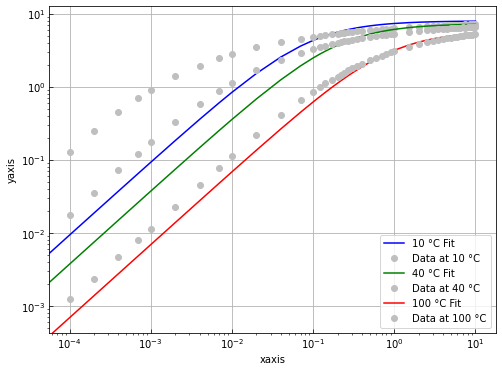

In [40]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from lmfit import Model 
from lmfit import Parameters
from IPython.display import display

_MODELS = [
    "Langmuir", "Quadratic", "BET", "Henry", "TemkinApprox", "DSLangmuir"
]

tick_style = {'direction' : 'in', 
			 'length' : 4, 
			 'width' : 0.7, 
			 'colors' : 'black'}

r = 8.314 
bold = '\033[1m' #for making text bold
unbold = '\033[0m' #for removing bold text

##############################################################################
########################### Isotherm models ##################################
##############################################################################

########## x is pressure ##############

#Single site langmuir forms
def langmuir1(x, q, b):
    return  (q * b * x) / (1 + b * x)

def langmuirlin1(x, q, b):
    return ( (x / (b * q) ) + (1 / (q) ) )

def langmuirlin2(x, q, b):
    return ( (1 / (b * q) ) + (x / (q) ) )

#Single site langmuir form with temperature dependent form
def langmuirTD(x, t, q, b0, h):
    b = b0*np.exp(-h/(r*t))
    return q * ( (b * x) / (1 + b * x) )

###############################################
# Dual site langmuir forms -  normal and temperature dependent form
def dsl(x, q1, q2, b1, b2):
    site1 = q1*( (b1 * x) / (1 + b1 * x) )
    site2 = q2*( (b2 * x) / (1 + b2 * x) )
    return site1 + site2

def dslTD(x, t, q1, q2, h1, h2, b01, b02):
    b1 = b01 * np.exp(-h1 / (r * t) )
    b2 = b02 * np.exp(-h2 / (r * t) )
    site1 = q1*( (b1 * x) / (1 + b1 * x) )
    site2 = q2*( (b2 * x) / (1 + b2 * x) )
    return site1 + site2

#################################################


def mdr_temp(x, t, n0, n1, a, b, e):
    k = (r*t)/(b*e)
    term1a = (1 - np.exp( - a * x) )* n0
    term1b = np.exp((-k * ((np.log(1/x))**2)))
    term2 = np.exp( - a * x) * n1 * x
    return term1a * term1b + term2

def mdr(x, n0, n1, a, c):
    term1a = (1 - np.exp( - a * x) )* n0
    term1b = np.exp((-c * ((np.log(1/x))**2)))
    term2 = np.exp( - a * x) * n1 * x
    return term1a * term1b + term2

################################################
#Calculation for b0 from obtained single langmuir parameters to be used as an initial guess for 'deltaH_langmuir'
def henry(x, kh): #Henry's law function for the henry region calculation
    return [i*kh for i in x]

def b0_calc(b, h, t):
    return np.exp(np.log(b) + h/(r*t))
    

####################### TYPE III, IV, V isotherms #################################

#BET Extension for type IV and V isotherms

# For a maximum (2n-1) layers which can be fit into a capillary:
def BET_ext1(x, c, n, g, q):
    #g = np.exp(h/(r*t))
    term1 = (c*x)/(1-x)
    term2_num = 1 + (((n * g) / 2) - n) * x**(n - 1) - (n * g - n + 1)*x**n + (n * g /2)*x**(n + 1)
    term2_den = 1 + (c - 1)*x + ((c * g/2) - c)*x**n - (c * g /2)*x**(n + 1)
    return term1 * (term2_num / term2_den) * q

# For a maximum number of 2n layers:
def BET_ext2(x, c, n, g, q):
    #g = np.exp(h/(r*t))
    term1 = (c*x)/(1-x)
    term2_num = 1 + (((n * g) / 2) - n / 2) * x**(n - 1) - (n * g + 1)*x**n + (n * g /2 + n / 2)*x**(n + 1)
    term2_den = 1 + (c - 1)*x + ((c * g/2) - c/2)*x**n - (c * g /2 + c / 2)*x**(n + 1)
    return term1 * (term2_num / term2_den) * q
    
# Do and Do isotherm
def DoDo(x, ns, kf, nu, ku, m):
    term1 = (ns * kf * x)/( (1 - x)*(1 + (kf - 1)*x))
    term2 = (nu * ku * x**m)/(1 + ku * x**m)
    return term1 + term2

def GAB(x, n, ka, ca):
    num = n * ka * ca * x
    den = (1 - ka * x) * (1 + (ca - 1) * ka * x)
    return num / den


###############################################################################
##################### EXTENDED MODELS ##################################

#Extended dual site langmuir model for the prediction of binary adsorption
#This calculates the absolute adsorption of A wrt pressure
def ext_dslA(x, t, q1A, q2A, h1A, h2A, b01A, b02A, h1B, h2B, b01B, b02B, yA):
    b1A = b01A*np.exp(-h1A/(r*t))
    b2A = b02A*np.exp(-h2A/(r*t))
    b1B = b01B*np.exp(-h1B/(r*t))
    b2B = b02B*np.exp(-h2B/(r*t))
    yB = 1 - yA    
    e1 = q1A * (b1A * x * yA) / (1 + (b1A * x * yA) + (b1B * x * yB) )
    e2 = q2A * (b2A * x * yA) / (1 + (b2A * x * yA) + (b2B * x * yB) )
    return e1 + e2

def ext_dslB(x, t, q1B, q2B, h1A, h2A, b01A, b02A, h1B, h2B, b01B, b02B, yB):
    b1A = b01A*np.exp(-h1A/(r*t))
    b2A = b02A*np.exp(-h2A/(r*t))
    b1B = b01B*np.exp(-h1B/(r*t))
    b2B = b02B*np.exp(-h2B/(r*t))
    yA = 1 - yB    
    e1 = q1B * (b1B * x * yB) / (1 + (b1B * x * yB) + (b1A * x * yA) )
    e2 = q2B * (b2B * x * yB) / (1 + (b2B * x * yB) + (b2A * x * yA) )
    return e1 + e2

def sel(qA, qB, yA):
    return (qA/qB)/(yA/(1-yA))


############# EMPIRICAL MODELS ################
def sips(x, q, b, n):
    return q * ( ( (b * x)**(1 / n) ) / (1 + (b * x)**(1 / n) ) )

def toth(x, q, b, t):
    return q * ( ( b * x) / ( (1 + (b * x)**t)**(1 / t) ) )
    
################################################################################
    
#############################################################################
######################      ERROR CALCS       ###############################
############################################################################
    
    
######### R squared calculation ###########
def r2(x, y, f, c):
    residuals = y - f(x, *c)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    result = 1 - (ss_res / ss_tot)
    if result <= 0:
        return 0.00000
    else:
        return result
def r2fix(x, y, result):
    residuals = y - result
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    rsq = 1 - (ss_res / ss_tot)
    return rsq

#This additional form of R squared calculation was required due to an error...
#...when using henrys law in the above function
def r2hen(pressures, uptake, f, hen):
    residuals = uptake - f(pressures, hen)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((uptake-np.mean(uptake))**2)
    result = 1 - (ss_res / ss_tot)
    if result <= 0:
        return 0.00000
    else:
        return result
    
def mse(x, y, f, c):
    y_predicted = f(x, *c)
    return np.square(np.subtract(y, y_predicted)).mean()

colours = ['b', 'g', 'r', 'c', 'm', 'y', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:olive']

def henry_approx(df, keyPressures, keyUptakes, display_hen=False, tolerance=0.999, henry_only=False):
    #This section finds the henry region of the datasets
    x = []
    y = []         
    for i in range(len(keyPressures)):
        xi = np.insert(np.array(df[keyPressures[i]].values), 0, 0)
        yi = np.insert(np.array(df[keyUptakes[i]].values), 0, 0)
        x.append(xi)
        y.append(yi)
        del xi
        del yi

    henry_constants = []
    henry_limits = []
    henry_rsq = []
    rsq_lst = []
    hen_lst = []
    henry_len = []
    errHen = []
    i = 0

    for dataset in y:
        rsq = 1
        x_ = x[i]
        x_henry = [x_[0], x_[1], x_[2]] #Starting with a minimum of two datapoints
        counter = 3 
        rsq_ilst = []
        hen_ilst = []
        #This loop adds data points while the points correspond to a henry fit with an R^2 of above 0.9995
        while rsq > 0 and counter < len(x_): 
            x_henry.append(x_[counter])
            y_henry = dataset[:len(x_henry)]

            hen= y_henry[-1] / x_henry[-1]
            rsq = round(r2hen(x_henry, y_henry, henry, hen),5) #r squared calc.
            rsq_ilst.append(rsq)
            hen_ilst.append(hen)
            counter += 1
        rsq_lst.append(rsq_ilst) 
        hen_lst.append(hen_ilst)
        #plt.figure()


        abtol = []
        itol = []
        i2 = 0
        for rsq in rsq_ilst:
            if rsq > tolerance:
                abtol.append(rsq)
                itol.append(i2)
            i2 += 1
        if abtol == []:
            maxrsq = max(rsq_ilst)
            rsqidx = rsq_ilst.index(maxrsq)
        else:
            rsqfin = min(abtol)
            minidx = abtol.index(rsqfin)
            rsqidx = itol[minidx]
            maxrsq = rsq_ilst[rsqidx]

        henidx = rsqidx + 2

        henry_len.append(henidx+1)
        #Saving Henry region parameters to later display
        henry_constants.append(hen_ilst[rsqidx])
        henry_limits.append(x_henry[henidx])
        henry_rsq.append(rsq_ilst[rsqidx])
        # sometimes data may not have a good henry region fit, which could abort the above while loop after the first
        # iteration. This piece of code warns the user of this

        if henidx+1 < 4:
            errHen.append(str(i+1))
        i += 1

    if henry_only == True:
        return henry_constants

    if errHen != []:
        print(unbold + 'WARNING: Henry region for dataset(s) ' + ', '.join(errHen) + ' were found to be made up of less than 4 points.')
        print('         This may affect accuracy of results.')
        print('         Henry region tolerance may be entered after log plot toggle parameter (default = 0.9999).')  

    #Creating dataframe for henry constants
    df_henry = pd.DataFrame(list(zip(henry_constants, henry_limits, henry_len, henry_rsq)), 
                            columns=['Henry constant (mmol/(bar.g))',
                                    'Upper limit (bar)','datapoints', 'R squared'])
    if display_hen == True:
        display(pd.DataFrame(df_henry))
    
    return henry_constants

def get_model(model):
    if model == "Langmuir":
        return langmuir1
    if model == "Langmuir linear 1":
        return langmuirlin1
    if model == "Langmuir linear 2":
        return langmuirlin2


def get_guess_params(model, df, key_uptakes, key_pressures):

    if model != "BDDT 2n" or model != "BDDT 2n-1" or model != "DoDo":
        henry_lim = henry_approx(df, key_pressures, key_uptakes, 0.999, True, True)
        saturation_loading = [1.1 * df[key_uptakes[i]].max() for i in range(len(key_pressures))]
        langmuir_b = [kh / qsat for (kh, qsat) in zip(henry_lim, saturation_loading)]

    if "Langmuir" in model and model != "Langmuir TD":
        return {
            "b": langmuir_b,
            "q" : saturation_loading
        }

    if model == "Langmuir TD":
        return {
            "b0": langmuir_b,
            "q" : saturation_loading,
            "h" : 5000
        }
    
    if model == "DSL":
        return {
            "q1": 0.5 * saturation_loading,
            "b1": 0.4 * langmuir_b,
            "q2": 0.5 * saturation_loading,
            "b2": 0.6 * langmuir_b
        }
    
    if model == "GAB":
        return {
            "n": saturation_loading,
            "ka": langmuir_b,
            "ca": 0.01 * langmuir_b
        } 





class IsothermFit:
    def __init__(self, 
                df, 
                compname, 
                temps, 
                keyPressures, 
                keyUptakes,
                logplot=False,
                model=None, 
                guess=None,  
                meth='tnc',
                x=[],
                y=[],
                params=[]):

        self.df = df                 #Dataframe with uptake vs. pressure data
        self.temps = temps           #Temp in deg C
        self.meth = meth             #Optional to choose mathematical fitting method in lmfit (default is leastsq)
        self.name = compname             #Name of component

        self.keyPressures = keyPressures #names of the column headers for pressure and uptakes
        self.keyUptakes = keyUptakes    #
        self.model = model
        self.logplot = logplot
        self.x = x
        self.y = y
        self.params = params

        # ! Dictionary of parameters as a starting point for data fitting
        self.guess = get_guess_params(model, df, keyUptakes, keyPressures)
        # Override defaults if user provides param_guess dictionary
        if guess is not None:
            for param, guess_val in guess.items():
                if param not in list(self.guess.keys()):
                    raise Exception("%s is not a valid parameter"
                                    " in the %s model." % (param, model))
                self.guess[param] = guess_val

    def fit(self, cond=True, show_hen=False, hen_tol=0.999):
        # Reading data from dataframe with respect to provided keys and adding a 0,0 point to dataset
        x2 = []
        y2 = []         
        for i in range(len(self.keyPressures)):
            xi = np.insert(np.array(self.df[self.keyPressures[i]].values), 0, 0)
            yi = np.insert(np.array(self.df[self.keyUptakes[i]].values), 0, 0)
            x2.append(xi)
            y2.append(yi)
            del xi
            del yi
      
        if self.model == "Langmuir linear 1":
            for i in range(len(self.keyPressures)):
                self.x.append([1 / p for p in x2[i]])
                self.y.append([1 / q for q in x2[i]])

        if self.model == "Langmuir linear 2":
            for i in range(len(self.keyPressures)):
                self.y.append([p / q for (p, q) in zip(x2[i], y2[i])])
                self.x.append([i for i in x2])
        
        if self.model == "MDR" or self.model == "MDR TD":
            for i in range(len(self.keyPressures)):
                pressure = x2[i]
                self.x.append(np.array([p / pressure[-1] for p in x2[i]]))
                self.y.append([i for i in y2])
                del pressure
        else:
            self.x = x2
            self.y = y2

        henry_constants = henry_approx(self.df, self.keyPressures, self.keyUptakes, show_hen, hen_tol)
       
        # SINGLE LANGMUIR
        if "Langmuir" in self.model and self.model != "Langmuir TD":
            isotherm = get_model(self.model)
            gmod = Model(isotherm)
            if cond == True:
                print("Constraint 1: q sat = q_init for all temp")
                print("Constraint 2: qsat*b = Henry constant for all temp")
            c = []

            q_guess = self.guess['q']
            b_guess = self.guess['b']

            for i in range(len(self.keyPressures)):
                pars = Parameters()
                pars.add('q', value=q_guess[i], min=q_guess[i], max=q_guess[i]+0.001)
                #Creating intermediate parameter delta that will fix KH = b*q

                if cond == True:
                    pars.add('delta', value=henry_constants[i], vary=False) 
                    pars.add('b', expr='delta/q') #KH = b*q
                else:
                    pars.add('b', value=b_guess[i], min=0)
                
                results = gmod.fit(self.y[i], pars, x=self.x[i], method=self.meth)
                cee = [results.values['q'], results.values['b']] 
                self.params.append(results)
                c.append(cee)
                del results
                del pars
            #allocating variables and creating dataframe
            #UNFORMATTED VARIABLES
            q_ = [param[0] for param in c]
            b_ = [param[1] for param in c]

            #FORMATTED VARIABLES
            qmax = [np.round(param[0], 3) for param in c]
            b = ["{:.3e}".format(param[1]) for param in c]

            # Checking r squared of fits
            r_sq = [r2(self.x[i], self.y[i], isotherm, c[i]) for i in range(len(self.keyPressures))]
            se = [mse(self.x[i], self.y[i], isotherm, c[i]) for i in range(len(self.keyPressures))]
            

            df_result = pd.DataFrame(list(zip(self.temps, qmax, b, r_sq, se)), columns=['Temperature (oC)','Qmax (mmol/g)',
                                                                                  'b (1/bar)', 'R squared', 'MSE'])
            #displaying dataframe
            display(pd.DataFrame(df_result))
            
            #calculating heat of adsorption
            T = np.array([1/(temp+273) for temp in self.temps])
            ln_b = np.array([np.log(i) for i in b_])
            mH, bH, rH, pH, sterrH = stats.linregress(T,ln_b)
            h = -0.001*mH*r
            
            print("_______________________________________________________________________")
            print("Heat of adsorption: " + str(round(h,2)) + " kJ/mol. \n" +
                  "R sq of Van't Hoff: " + str(round(rH, 4)))
            
            #b0 is also calculated and displayed to the user.
            #This can be then fed back into the class with delta H to fit to the van't Hoff form of langmuir
            b0 = np.exp(bH)
            print("List for intial guess values to feed into the temperature dependent Langmuir model:")
            print([q_[0], b_[0], h, b0])
    
    def plot(self):
        p=np.linspace(0, 10, 301)

        ##### Plotting results #####
        plt.figure(figsize=(8, 6))
        #plt.title()
        if self.logplot == True:
            plt.xscale("log")
            plt.yscale("log")
        plt.xlabel('xaxis')
        plt.ylabel('yaxis')
        plt.tick_params(**tick_style)

        for i in range(len(self.keyPressures)):
            plt.plot(self.x[i], self.params[i].best_fit, '-', color = colours[i], 
                     label="{temps} °C Fit".format(temps=self.temps[i]))
            plt.plot(self.x[i], self.y[i], 'ko', color = '0.75', 
                     label="Data at {temps} °C".format(temps=self.temps[i]))

        plt.grid()
        plt.legend()
        plt.show()

df1 = pd.read_csv('Computational Data (EPFL) CO2.csv')

compname = 'CO2'
temps = [10, 40, 100]
meth = 'tnc'
keyUptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']
keyPressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']

#keyPressures = ['Pressure1', 'Pressure2', 'Pressure3']
#keyUptakes = ['Uptake1', 'Uptake2', 'Uptake3']
tolerance = 0.9999 # set minimum r squared value

langmuir = IsothermFit(df1, compname, temps, keyPressures, keyUptakes, True, "Langmuir")
langmuir.fit(False)
langmuir.plot()

